The above is my example of ***exploratory creativity*** and ***combinational creativity***. 

In [ ]:
%matplotlib inline

In [ ]:
# Link your google drive to this notebook
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
from pathlib import Path

# Print current working directory
print('Now we are at ', end='')
!pwd

# Create the folders we need
if '/content/gdrive/My Drive/Colab_Images' not in os.getcwd():
  Path("gdrive/My Drive/Colab_Images/outputs").mkdir(parents=True, exist_ok=True)
  %cd ./gdrive/My\ Drive/Colab_Images

# Download the sample style and content images
# Comment out these two lines if you don't need them
# !wget -q -nc http://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg # -q is for quiet downloading file
# !wget -q -nc http://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg # -nc is for not redownloading file

# List files and directories under current working directory
!ls

Now we are at /content/gdrive/My Drive/Colab_Images
 dancing.jpg	'levi ackerman.jpg'   picasso.jpg   style.jpg
 Fushiguro.jpg	 outputs	      place.jpg


In [ ]:
content_img_input = input("Please intput the content image name: ")
content_img = content_img_input + '.jpg'

Please intput the content image name: Fushiguro


In [ ]:
# Choose the files you want as style and content images for doing style transfer
# Make sure the files are printed above!
style_img_name = 'style.jpg'
content_img_name = content_img

Neural Transfer Using PyTorch
=============================

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Now the notebook is using: {}'.format('GPU' if device == torch.device('cuda') else 'CPU'))

Now the notebook is using: CPU


In [ ]:
# desired size of the output image
imsize = (512,512) if torch.cuda.is_available() else (128,128)  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    try:
      image = Image.open(image_name)
    except FileNotFoundError:
      print('The file "{}" cannot be found. Please check it again.'.format(image_name[2:]))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./" + style_img_name)
content_img = image_loader("./" + content_img_name)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

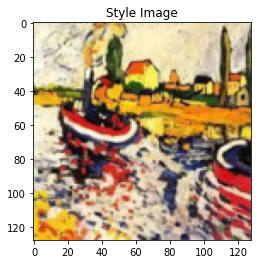

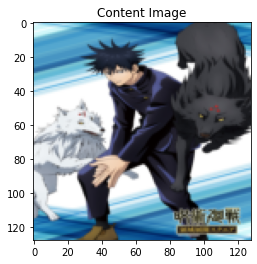

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Loss Functions
--------------
Content Loss
~~~~~~~~~~~~

The content loss is a function that represents a weighted version of the
content distance for an individual layer. The function takes the feature
maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the
weighted content distance $w_{CL}.D_C^L(X,C)$ between the image $X$ and the
content image $C$. The feature maps of the content image($F_{CL}$) must be
known by the function in order to calculate the content distance. We
implement this function as a torch module with a constructor that takes
$F_{CL}$ as an input. The distance $\|F_{XL} - F_{CL}\|^2$ is the mean square error
between the two sets of feature maps, and can be computed using ``nn.MSELoss``.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image the content losses will be
computed at the desired layers and because of auto grad, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a ``forward`` method that computes the content
loss and then returns the layer’s input. The computed loss is saved as a
parameter of the module.




In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Style Loss
~~~~~~~~~~

The style loss module is implemented similarly to the content loss
module. It will act as a transparent layer in a
network that computes the style loss of that layer. In order to
calculate the style loss, we need to compute the gram matrix $G_{XL}$. A gram
matrix is the result of multiplying a given matrix by its transposed
matrix. In this application the given matrix is a reshaped version of
the feature maps $F_{XL}$ of a layer $L$. $F_{XL}$ is reshaped to form $\hat{F}_{XL}$, a $K$\ x\ $N$
matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is the
length of any vectorized feature map $F_{XL}^k$. For example, the first line
of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.

Finally, the gram matrix must be normalized by dividing each element by
the total number of elements in the matrix. This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$ dimension yield
larger values in the Gram matrix. These larger values will cause the
first layers (before pooling layers) to have a larger impact during the
gradient descent. Style features tend to be in the deeper layers of the
network so this normalization step is crucial.




In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

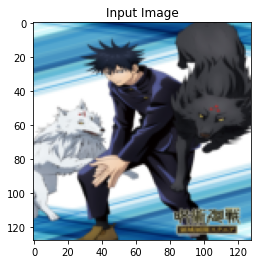

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 271.014069 Content Loss: 44.466885

run [100]:
Style Loss : 78.972351 Content Loss: 46.782455

run [150]:
Style Loss : 41.002304 Content Loss: 46.422527

run [200]:
Style Loss : 28.381025 Content Loss: 45.179050

run [250]:
Style Loss : 22.578148 Content Loss: 43.821404

run [300]:
Style Loss : 18.902687 Content Loss: 42.485977



In [ ]:
# plt.figure()
# imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
# plt.ioff()
# plt.show()

In [ ]:
def imsave(tensor, filepath='./outputs/'+style_img_name[:-4]+'_'+content_img_name[:-4]+'.jpg'):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  
  try:
    image.save(filepath)
    print('File saved!')
  except ValueError:
    print('ERROR: The output file format could not be determined!')
  except OSError:
    print('ERROR: The output file could not be written!')

In [ ]:
file_path_ = './outputs/answer.jpg'

In [ ]:
imsave(output, filepath = file_path_)

File saved!


**Cut the Output Image**
-------------------
reference: https://blog.csdn.net/xc_zhou/article/details/87866317

In [ ]:
import sys
import numpy as np

In [ ]:
file = '/content/gdrive/My Drive/Colab_Images/outputs/answer.jpg'

In [ ]:
image = Image.open(file)

In [ ]:
def cut_image(image):
  width, height = image.size
  item_width = width/2
  box_list = []
  
  for i in range(0,2):
    for j in range(0,2):
      box = (j*item_width, i*item_width, (j+1)*item_width, (i+1)*item_width)
      box_list.append(box)

  image_list = [image.crop(box) for box in box_list]
  return image_list

In [ ]:
image_array = cut_image(image)

In [ ]:
def save_images(image_array):
  index = 0
  for image in image_array:
    image.save('./outputs/'+str(index)+'.jpg')
    index = index + 1

In [ ]:
save_images(image_array)

Display the Puzzle
-------------------

In [ ]:
import random
puzzle_index = []
puzzle_index = random.sample(range(4),4)

In [ ]:
puzzle_index

[2, 1, 0, 3]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img

In [ ]:
path_for_puzzle = '/content/gdrive/My Drive/Colab_Images/outputs/'

In [ ]:
# show
def display_the_puzzle():
  rows = 1
  cols = 4
  axes=[]
  fig = plt.figure()

  for i in range(rows*cols):
      image = img.imread(path_for_puzzle + str(puzzle_index[i]) + '.jpg')
      axes.append(fig.add_subplot(rows, cols, i+1) )
      subplot_title=("Number "+str(i))
      axes[-1].set_title(subplot_title)  
      plt.imshow(image)
  fig.tight_layout()    
  plt.show()

  # place
  image = img.imread('/content/gdrive/My Drive/Colab_Images/place.jpg')

  plt.subplot(1,2,1)
  plt.title("Place")  
  plt.imshow(image)
  # original picture
  image_2 = img.imread('/content/gdrive/My Drive/Colab_Images/' + content_img_input + '.jpg')
  plt.subplot(1,2,2)
  plt.title("Original")  
  plt.imshow(image_2)
      
  plt.show()

In [ ]:
def guess():
  while(True):
    answer = []
    print("Please type number corresponding to its place: ")
    answer = input("Please type the corresponding numbers to the place A, B, C, D:")
    
    try:
      answer_int_list = list(map(int, answer))
    except:
      print("Please Try Again.")
      continue
    for i in range(4):
      try:
        if puzzle_index[answer_int_list[i]] != i:
          print("Please Try Again.")
          break
      except:
        print("Please Try Again.")
        break
    else:
      correct = False
      for i in range(4):
        if puzzle_index[answer_int_list[i]] == i:
          correct = True
          continue
      if correct:
        print("Congratulations.")
      return

In [ ]:
def answer_display():
  plt.figure()
  imshow(output, title='Answer Image')

  # sphinx_gallery_thumbnail_number = 4
  plt.ioff()
  plt.show()

In [ ]:
def game():
  guess()
  answer_display()

**Let's Start the Game !!!**
=============================================

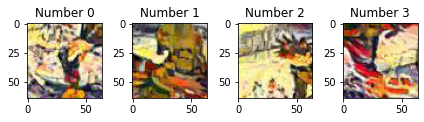

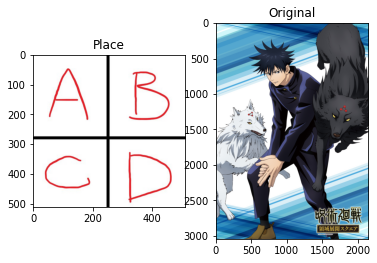

In [ ]:
display_the_puzzle()

Please type number corresponding to its place: 
Please type the corresponding numbers to the place A, B, C, D:2103
Congratulations.


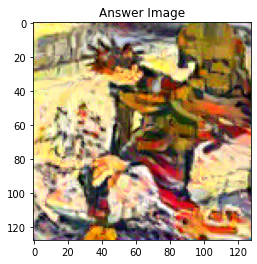

In [ ]:
game()

The following the the example of ***transformational creativity***.

In [ ]:
%matplotlib inline

In [ ]:
# Choose the files you want as style and content images for doing style transfer
# Make sure the files are printed above!
style_img_name = 'style_1.jpg'
content_img_name = 'transformational_creativity.jpg'

In [ ]:
# desired size of the output image
imsize = (512,512) if torch.cuda.is_available() else (128,128)  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    try:
      image = Image.open(image_name)
    except FileNotFoundError:
      print('The file "{}" cannot be found. Please check it again.'.format(image_name[2:]))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./" + style_img_name)
content_img = image_loader("./" + content_img_name)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

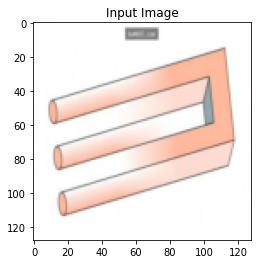

In [ ]:
input_img = content_img.clone()
input_img_2 = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 178.850204 Content Loss: 30.097839

run [100]:
Style Loss : 12.565891 Content Loss: 27.467588

run [150]:
Style Loss : 3.034867 Content Loss: 23.654427

run [200]:
Style Loss : 1.805154 Content Loss: 21.175459

run [250]:
Style Loss : 1.460595 Content Loss: 19.870781

run [300]:
Style Loss : 1.316828 Content Loss: 19.201914



In [ ]:

imshow(output, title='Output Image')


imshow(input_img_2, title='Input Image')

plt.ioff()
plt.show()

The picture above can interpret into totally different stories with different views. 

In this case, we can learn that the output with NST is an classical style painting with beautiful and various colors.  The original picture can interpret as different object. Either a fork with two ends or a fork with three ends are both correct. However, the fact is that this is only an picture with simple lines and colors. 

All we can learn from this picture is that there is not absolutely right or wrong viewpoints. We have to stand in other's viewpoint to embrace a better understanding.